## Assignment 6 - Markov Random Fields

In the last two assignment we are going to look at two additional techniques used in artificial intelligence and robotic systems. 
The first one are Markov Random Fields (MRF) in this assignment and second one is the Markov Decision Process (MDP) in the 7th one. 

Markov Random Fields are often used in situation where we know how the interaction between small groups of variables behaves. In other words, we use MRFs when we think that global variable configurations arise as a consequence of the interactions between smaller groups of variables. 

Just as in the assignment for Bayes Networks, here we will complete a class that represents a Markov Random Field.


In [3]:
%autosave 0
import itertools
import numpy as np
from numpy import array


class Mrf(object):

    def __init__(self, domain, cliques):
        ''' Domain: Values that the variables can take
            Cliques: List of tuples (variables,potential_matrix) '''
        self.domain = domain
        self.cliques = cliques
        self.variables = set()
        for vs, matrix in cliques:
            self.variables.update(vs)

    def get_potential(self, configuration):
        ''' Return the potential (unnormalized) of the given variable configuration)'''
        potential = 1
        for i in self.cliques:
            variables = list(i)[0]
            values = [configuration[j] for j in variables]
            potential *= list(i)[1][tuple(values)]
        return potential

    def get_configurations(self):
        ''' Returns a list of dicts with all possible variable configurations '''
        configurations = []
        for values in itertools.product(self.domain, repeat=len(self.variables)):
            configurations.append(dict(zip(self.variables, values)))

        return configurations

    def compute_Z(self):
        ''' Return the normalization constant'''
        configurations = self.get_configurations()
        z = 0
        for i in configurations:
            potential = self.get_potential(i)
            z += potential
        return z

    def argmax(self):
        '''Return a dict with a most likely configuration and its unnormalized potential'''
        configurations = self.get_configurations()
        largestPotential = 0
        for i in configurations:
            potential = self.get_potential(i)
            if potential > largestPotential:
                largestPotential = potential
                MostLikelyConfigurations = i
        return MostLikelyConfigurations, largestPotential

Autosave disabled


To create the MRF we need to give two arguments. 
1. We need to specify the domain of the variables, which for our purposes will be [0, 1]
2. Define the clique functions. In our case, the clique functions will be only over one or two variables, so they can be modelled easily with a 1x2 or 2x2 arrays. 

In [4]:
# Example with only two unary potentials and one pairwise potential (in practice you will have many)
domain = [0, 1]

# Unary potential on v1
variables_unary_v1 = array((1, ))
potential_unary_v1 = array((0.1, 0.8))  # the state 0 has a potential of 0.1, state 1 has a potential of 0.8
variables_unary_v2 = array((2, ))
potential_unary_v2 = array((0.3, 0.6))  # the state 0 has a potential of 0.3, state 1 has a potential of 0.6

# Pairwise potential
variables_pairwise = array([1, 2])  # A potential over variables 1 and 2
potential_pairwise = array([[1, 0],
                            [0, 1]])  # States where v1 and v2 are equal have a potential of 1, else 0

# Create the Mrf
my_mrf = Mrf(domain, [(variables_unary_v1, potential_unary_v1),
                      (variables_unary_v2, potential_unary_v2),
                      (variables_pairwise, potential_pairwise)])

In [5]:
# Notice that we used numpy arrays to create the potentials, this allows us to use easy indexing with tuples
matrix_position = (1, 1)
print potential_pairwise[matrix_position]


1


### Exercise 1: Implement the `get_potential` method of the `Mrf` class

Use the definition of Markov Random Fields to compute the total potential that is associated to an assignment (configuration) of the variables. For this you can ignore the normalization constant $Z$.

The input will be a configuration (see below: my_configuration) of the variables in form of a dictionary, and the output will be the numeric value of the potential:

In [6]:
# uncomment this code when you have implemented the method

my_configuration = {1: 1, 2: 1, 3: 1, 4: 0}  # Assuming we have 4 variables
potential = my_mrf.get_potential(my_configuration)
print potential


0.48


### Exercise 2: Implement the `argmax` method

If you solved the previous exercise, you can compute potentials from the MRF. 
Now you can compute the most likely state. 
This method should return the configuration where the argmax is achieved, and the numeric value of the potential. 

In [7]:
# uncomment this code when you have implemented the method

configuration, value = my_mrf.argmax()
print configuration, value


{1: 1, 2: 1} 0.48


**Hint**: The `get_configurations` method returns a list of dicts with all possible variable configurations. This can be used to iterate over all possible variable configurations.

### Exercise 3: Implement the `compute_Z` method

The normalization constant Z is needed to compute actual probabilities from the MRF. 
Complete this method, which takes no arguments.

In [8]:
# uncomment this code when you have implemented the method

Z = my_mrf.compute_Z()
print Z


0.51


## Line-scan model

One of the classical examples of MRF is the image denoising task. MRFs are widely used in Computer Vision and 3D perception, although they are used to model a variety of tasks: modeling spatial relations between objects, the segmentation of image parts into different classes, stitching multiple images together (panorama mode), etc. 

In this tiny example, you have a binary digital line-scan camera, i.e. a camera that scans in only one row of pixels. However, this scan is a bit noisy, and we want to correct it. We associate **one variable to each pixel**. The input to the MRF is the image that was registered by the camera. The output represents the restored (denoised) image. 

###Model

We will have two types of potentials, unary and pairwise/binary. The unaries will model our belief in the sensor measurement (ON/OFF) and the pairwise potentials will model our belief that neighbouring pixels take similar values. 


`unaries_on`: the potentials for pixels that are registered as on (1x2 array)

`unaries_off`: the potentials for pixels that are registered as off (1x2 array)

`pairwise`: the potential for the 4 possibilities of pairwise configurations (2x2 array)



### Exercise 4: Build the MRF 

Complete the following function that constructs the MRF for the single image. Your input will be a `row`, a list of (0,1) representing the measurement from the camera and the potential functions required to construct the MRF.

In [9]:
def build_line_scan_mrf(row, unary_on, unary_off, pairwise):
    '''Returns and MRF for the described model and the observed row of pixels'''
    unaries = []
    count = 0
    for i in row:
        if i == 1:
            unaries.append((array((count, )), unary_on))
        else:
            unaries.append((array((count, )), unary_off))
        count += 1
    pairwise_cliques = []
    for i in xrange(len(row)):
        if i == 0:
            continue
        pairwise_cliques.append((array([i - 1, i]), pairwise))
    print pairwise_cliques
    print unaries
    return Mrf([0, 1], pairwise_cliques + unaries)


You can do some basic checks:

- If the unaries are very strong in comparison to the pairwise interaction, the output should equal the input
- If pairwise interactions are much stronger than the unaries, the output should be independent of the input

#### Visualization utiliy

To see the input/output of the MRF you can use the following utility functions. This can be useful to see the result of the argmax method. 

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt


def view_row(row):
    ''' Displays the row. If called multiple calls in a single cell it only displays last call'''
    img = array([row])
    plt.imshow(img, interpolation='nearest', cmap='hot')


def configuration2row(configuration):
    ''' Convert from a configuration in the mrf to the image row'''
    row = [0] * len(configuration.items())
    for pos, value in configuration.items():
        row[pos] = value

    return row


[1, 1, 1, 0, 1, 0, 0]


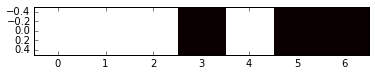

In [11]:
some_configuration = {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0}
row = configuration2row(some_configuration)
print(row)
view_row(row)


## Excercise 5: Questions

Experiment with the MRF class and complete the function below!

[(array([0, 1]), array([[ 0, 10],
       [10,  0]])), (array([1, 2]), array([[ 0, 10],
       [10,  0]])), (array([2, 3]), array([[ 0, 10],
       [10,  0]])), (array([3, 4]), array([[ 0, 10],
       [10,  0]])), (array([4, 5]), array([[ 0, 10],
       [10,  0]])), (array([5, 6]), array([[ 0, 10],
       [10,  0]])), (array([6, 7]), array([[ 0, 10],
       [10,  0]])), (array([7, 8]), array([[ 0, 10],
       [10,  0]])), (array([8, 9]), array([[ 0, 10],
       [10,  0]])), (array([ 9, 10]), array([[ 0, 10],
       [10,  0]]))]
[(array([0]), array([2, 1])), (array([1]), array([2, 1])), (array([2]), array([2, 1])), (array([3]), array([2, 1])), (array([4]), array([2, 1])), (array([5]), array([1, 3])), (array([6]), array([2, 1])), (array([7]), array([2, 1])), (array([8]), array([2, 1])), (array([9]), array([2, 1])), (array([10]), array([2, 1]))]


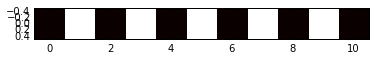

In [14]:
# Change this code as you wish

row = [0,0,0,0,0,1,0,0,0,0,0]

unary_on = array([1,3])
unary_off = array([2,1])
pairwise=array([[0,10],[10,0]])

mrf = build_line_scan_mrf(row, unary_on, unary_off, pairwise)
am, value = mrf.argmax()
view_row(configuration2row(am))


In [13]:
def short_questions():
    '''Return the truth value for the following statements about the pairwise interaction array:

    1. High values in the diagonal of the pairwise interaction array encourage uniform solutions 
        ([1 1 1 1] or [0 0 0 0])
    2. High values in the entries outside of the diagonal of the pairwise interaction array encourage 
        alternating solutions
    3. If all entries of a potential matrix are the same and this is the only type of potential in the MRF, 
        the output will be equal to the input.
    If the domain of the variables were discrete with K values (instead of binary)
        4. The interaction matrices should be of size K x K
        5. The interaction matrices should be of size 2 x 2 x ... x 2 x 2 (K times)
    If we had interactions over N variables (instead of two) (but still binary domain)
        6. The interaction matrices should be of size 2 x 2 x ... x 2 x 2 (N times)
        7. The interaction matrices should be of size N x N

    '''

    answer = [True, True, True, True, False, True, False]  # e.g [True,False,False,False,False,False,False] if you believe that all statements but
    # the first one are False.
    return answer
